In [1]:
import os
import re
from collections import Counter
import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from gensim.models import Word2Vec
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from wordcloud import WordCloud

In [2]:
file_path = 'IMDB.csv'
df = pd.read_csv(file_path, nrows=15656)

print(df.head())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [3]:
# import ssl
# import nltk

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download('punkt')
# nltk.download('stopwords')


In [4]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    words = word_tokenize(text.lower())

    words = [word for word in words if word not in stop_words]
    
    return ' '.join(words)

df['cleaned_review'] = df['review'].apply(clean_text)

print(df[['review', 'cleaned_review']].head())

/var/folders/_m/cqdg0r_s2pl9kz5nks9_ktn00000gn/T/ipykernel_33176/2708760753.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      cleaned_review  
0  one reviewers mentioned watching 1 oz episode ...  
1  wonderful little production filming technique ...  
2  thought wonderful way spend time hot summer we...  
3  basically theres family little boy jake thinks...  
4  petter matteis love time money visually stunni...  


In [5]:
df['tokenized_review'] = df['cleaned_review'].apply(word_tokenize)

print(df[['cleaned_review', 'tokenized_review']].head())

                                      cleaned_review  \
0  one reviewers mentioned watching 1 oz episode ...   
1  wonderful little production filming technique ...   
2  thought wonderful way spend time hot summer we...   
3  basically theres family little boy jake thinks...   
4  petter matteis love time money visually stunni...   

                                    tokenized_review  
0  [one, reviewers, mentioned, watching, 1, oz, e...  
1  [wonderful, little, production, filming, techn...  
2  [thought, wonderful, way, spend, time, hot, su...  
3  [basically, theres, family, little, boy, jake,...  
4  [petter, matteis, love, time, money, visually,...  


In [6]:
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

In [7]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

df['lemmatized_review'] = df['tokenized_review'].apply(lambda tokens: [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens])

print(df[['tokenized_review', 'lemmatized_review']].head())


                                    tokenized_review  \
0  [one, reviewers, mentioned, watching, 1, oz, e...   
1  [wonderful, little, production, filming, techn...   
2  [thought, wonderful, way, spend, time, hot, su...   
3  [basically, theres, family, little, boy, jake,...   
4  [petter, matteis, love, time, money, visually,...   

                                   lemmatized_review  
0  [one, reviewer, mention, watch, 1, oz, episode...  
1  [wonderful, little, production, film, techniqu...  
2  [thought, wonderful, way, spend, time, hot, su...  
3  [basically, there, family, little, boy, jake, ...  
4  [petter, matteis, love, time, money, visually,...  


In [8]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
print(df[['lemmatized_review', 'sentiment']].head())

                                              review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1


In [9]:
df['lemmatized_review_str'] = df['lemmatized_review'].apply(lambda tokens: ' '.join(tokens))

vectorizer_bow = CountVectorizer()

X_bow = vectorizer_bow.fit_transform(df['lemmatized_review_str'])

print(f'Bag of Words matrix shape: {X_bow.shape}')

Bag of Words matrix shape: (15656, 95330)


In [10]:
vectorizer_tfidf = TfidfVectorizer()

X_tfidf = vectorizer_tfidf.fit_transform(df['lemmatized_review_str'])

print(f'TF-IDF matrix shape: {X_tfidf.shape}')

TF-IDF matrix shape: (15656, 95330)


In [11]:
model_w2v = Word2Vec(sentences=df['lemmatized_review'], vector_size=100, window=5, min_count=1, workers=4)

print(model_w2v.wv['movie'])

def get_avg_word2vec(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

df['w2v_vector'] = df['lemmatized_review'].apply(lambda tokens: get_avg_word2vec(tokens, model_w2v))

print(df[['lemmatized_review', 'w2v_vector']].head())

[-1.5303003  -0.26032105  0.7754986   0.5696261   1.0086604  -1.496364
  0.8365243   2.2132025  -1.2109368  -2.3503568   0.47312614 -1.6690587
 -0.14786755  1.3048611   2.0179121   0.4567592   1.0827252   0.81566215
 -1.4146173  -1.829384   -0.9274264   0.6611283   0.8321237  -1.8498087
  1.8974123  -1.011385   -0.5314547   0.19156414 -1.9296905  -0.6408579
  1.2425342  -1.0719314   0.38888535 -2.061227   -0.7337477   0.8648868
  1.1685264  -1.1641479   0.70163214 -1.2508719  -0.6126088  -1.3481418
 -1.8098532   0.41421208  0.6799414  -1.51732    -0.5853598   0.458842
  1.6342368   0.30870205 -0.23534742 -0.89423877  0.35003614  1.1348816
 -0.12580155 -0.71848875  1.3876611  -0.7111873  -0.8460324   1.852224
 -0.38629243  0.36379248  0.481711   -0.4758618  -0.33922693  0.88846266
  0.32489914  1.2586263  -2.3420641   0.7131891   0.33563504  1.4442866
 -0.25120777  0.16994779  1.274797   -0.31851634  1.0478355   0.8655619
  1.2499163  -0.7242199  -1.5165902  -0.62620044  0.6056068   0.8

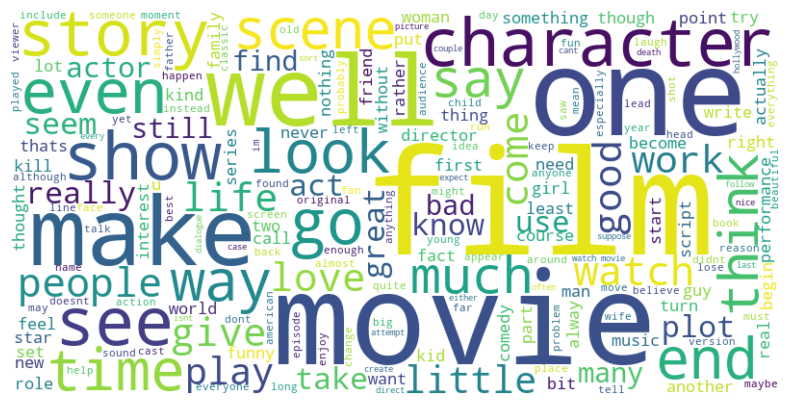

In [12]:
all_words = ' '.join([' '.join(tokens) for tokens in df['lemmatized_review']])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

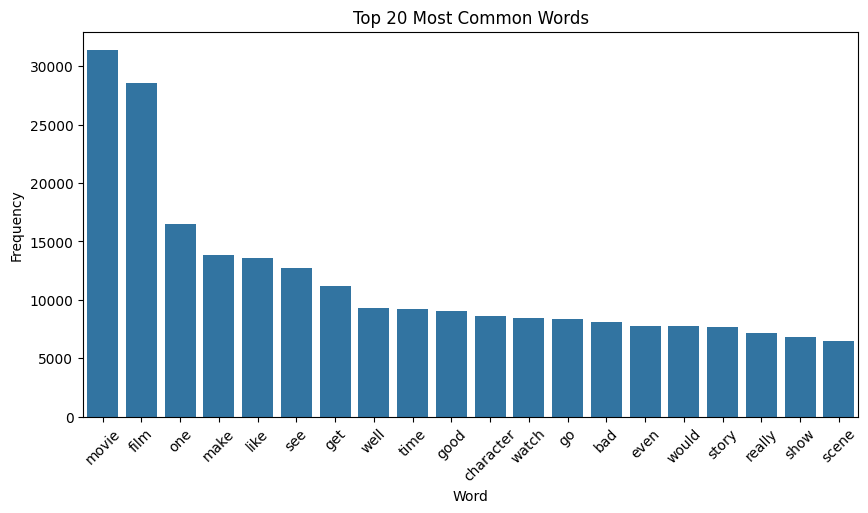

In [13]:
all_words_list = [word for tokens in df['lemmatized_review'] for word in tokens]

freq_dist = Counter(all_words_list)

most_common_words = freq_dist.most_common(20)

freq_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(10, 5))
sns.barplot(x='Word', y='Frequency', data=freq_df)
plt.xticks(rotation=45)
plt.title('Top 20 Most Common Words')
plt.show()

/var/folders/_m/cqdg0r_s2pl9kz5nks9_ktn00000gn/T/ipykernel_33176/2667726907.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


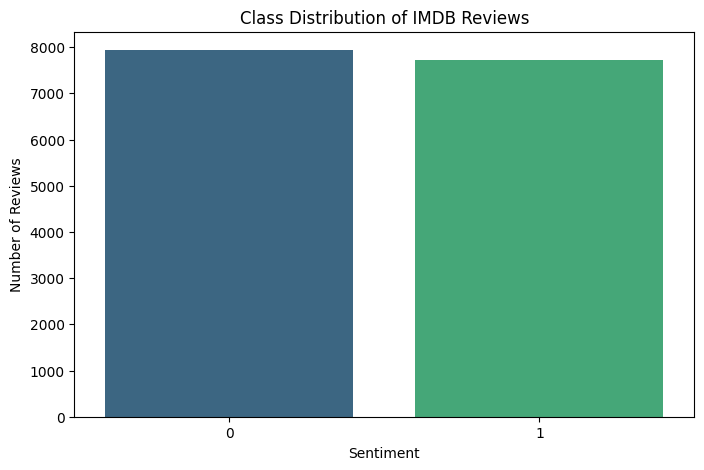

sentiment
0    7937
1    7719
Name: count, dtype: int64


In [14]:
class_distribution = df['sentiment'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Class Distribution of IMDB Reviews')
plt.show()

print(class_distribution)

In [15]:
X = df['lemmatized_review'].apply(lambda x: ' '.join(x))  # Join tokens back into a single string for each review
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Training set size: {len(X_train)}')
print(f'Testing set size: {len(X_test)}')


Training set size: 12524
Testing set size: 3132


In [16]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

models = {
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear'),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100)
}

for name, model in models.items():
    print(f'Training {name}...')
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    
    print(f'{name} accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))
    print('-'*60)

Training Naive Bayes...
Naive Bayes accuracy: 0.8576
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1588
           1       0.86      0.85      0.85      1544

    accuracy                           0.86      3132
   macro avg       0.86      0.86      0.86      3132
weighted avg       0.86      0.86      0.86      3132

------------------------------------------------------------
Training SVM...
SVM accuracy: 0.8784
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1588
           1       0.87      0.89      0.88      1544

    accuracy                           0.88      3132
   macro avg       0.88      0.88      0.88      3132
weighted avg       0.88      0.88      0.88      3132

------------------------------------------------------------
Training Logistic Regression...
Logistic Regression accuracy: 0.8784
              precision    recall  f1-score   support

          

In [17]:
param_grids = {
    'Naive Bayes': {
        'alpha': [0.1, 0.5, 1.0]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'max_iter': [100, 200, 500, 1000]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 500],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 500],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

best_models = {}
for name, model in models.items():
    print(f'Tuning hyperparameters for {name}...')
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_tfidf, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f'Best parameters for {name}: {grid_search.best_params_}')
    print(f'Best cross-validated accuracy for {name}: {grid_search.best_score_:.4f}')
    print('-'*60)

for name, model in best_models.items():
    print(f'Evaluating {name} with best hyperparameters...')
    y_pred = model.predict(X_test_tfidf)
    
    print(f'{name} accuracy: {accuracy_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))
    print('-'*60)


Tuning hyperparameters for Naive Bayes...
Best parameters for Naive Bayes: {'alpha': 1.0}
Best cross-validated accuracy for Naive Bayes: 0.8495
------------------------------------------------------------
Tuning hyperparameters for SVM...
Best parameters for SVM: {'C': 1, 'kernel': 'rbf'}
Best cross-validated accuracy for SVM: 0.8708
------------------------------------------------------------
Tuning hyperparameters for Logistic Regression...
Best parameters for Logistic Regression: {'C': 1, 'max_iter': 100}
Best cross-validated accuracy for Logistic Regression: 0.8689
------------------------------------------------------------
Tuning hyperparameters for Random Forest...
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
Best cross-validated accuracy for Random Forest: 0.8417
------------------------------------------------------------
Tuning hyperparameters for Gradient Boosting...
Best parameters for Gradient Boosting: {'learning_rate

Evaluating Naive Bayes with best hyperparameters...
Naive Bayes Accuracy: 0.8576
Naive Bayes Precision: 0.8577
Naive Bayes Recall: 0.8576
Naive Bayes F1-Score: 0.8576


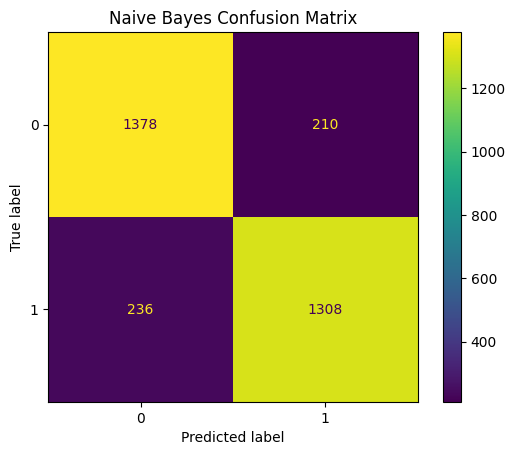

------------------------------------------------------------
Evaluating SVM with best hyperparameters...
SVM Accuracy: 0.8809
SVM Precision: 0.8812
SVM Recall: 0.8809
SVM F1-Score: 0.8809


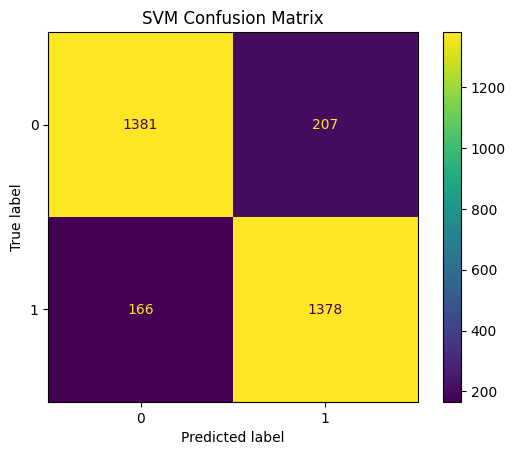

------------------------------------------------------------
Evaluating Logistic Regression with best hyperparameters...
Logistic Regression Accuracy: 0.8784
Logistic Regression Precision: 0.8784
Logistic Regression Recall: 0.8784
Logistic Regression F1-Score: 0.8784


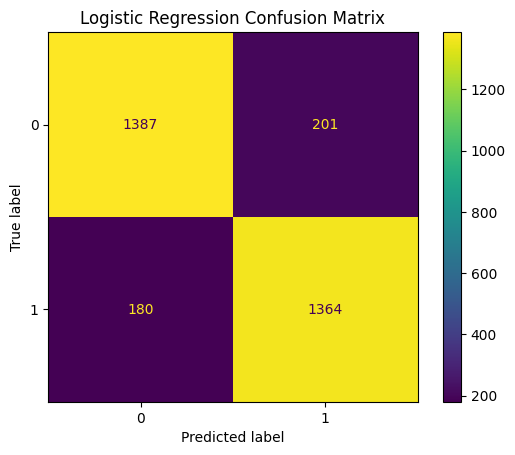

------------------------------------------------------------
Evaluating Random Forest with best hyperparameters...
Random Forest Accuracy: 0.8579
Random Forest Precision: 0.8584
Random Forest Recall: 0.8579
Random Forest F1-Score: 0.8578


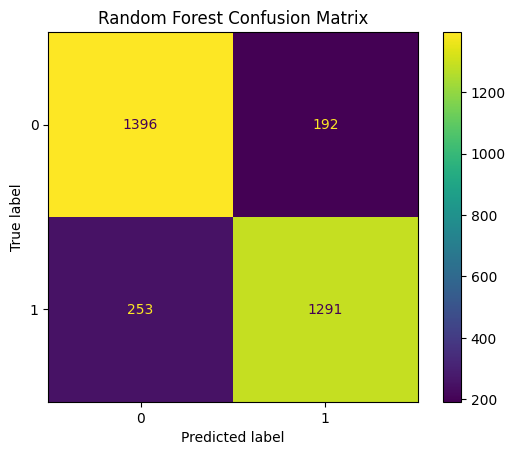

------------------------------------------------------------
Evaluating Gradient Boosting with best hyperparameters...
Gradient Boosting Accuracy: 0.8550
Gradient Boosting Precision: 0.8553
Gradient Boosting Recall: 0.8550
Gradient Boosting F1-Score: 0.8550


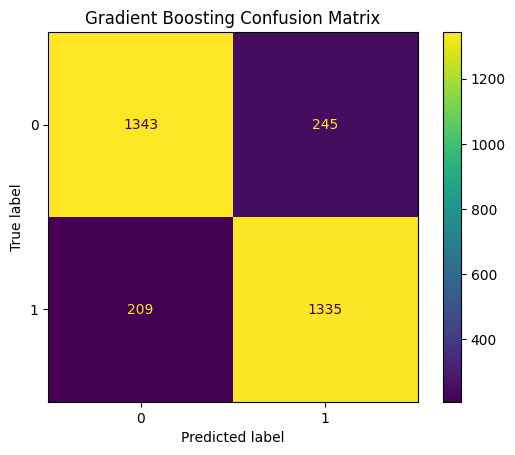

------------------------------------------------------------


In [18]:
for name, model in best_models.items():
    print(f'Evaluating {name} with best hyperparameters...')
    y_pred = model.predict(X_test_tfidf)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f'{name} Accuracy: {accuracy:.4f}')
    print(f'{name} Precision: {precision:.4f}')
    print(f'{name} Recall: {recall:.4f}')
    print(f'{name} F1-Score: {f1:.4f}')
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='viridis')
    plt.title(f'{name} Confusion Matrix')
    plt.show()
    
    print('-'*60)

Ensemble Model Accuracy: 0.8847
Ensemble Model Precision: 0.8847
Ensemble Model Recall: 0.8847
Ensemble Model F1-Score: 0.8847


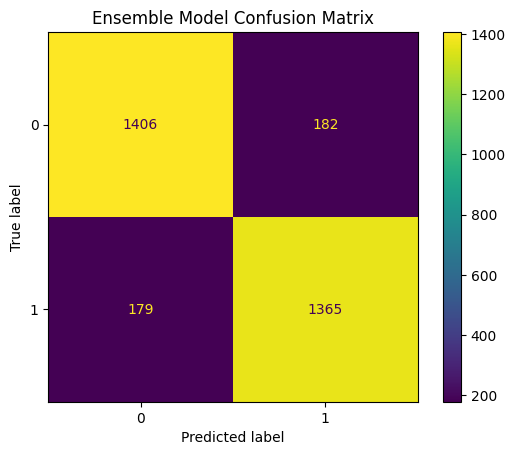

In [19]:
voting_clf = VotingClassifier(estimators=[
    ('nb', best_models['Naive Bayes']),
    ('svm', best_models['SVM']),
    ('lr', best_models['Logistic Regression']),
    ('rf', best_models['Random Forest']),
    ('gb', best_models['Gradient Boosting'])
], voting='hard')

voting_clf.fit(X_train_tfidf, y_train)

y_pred = voting_clf.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Ensemble Model Accuracy: {accuracy:.4f}')
print(f'Ensemble Model Precision: {precision:.4f}')
print(f'Ensemble Model Recall: {recall:.4f}')
print(f'Ensemble Model F1-Score: {f1:.4f}')

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=voting_clf.classes_)
disp.plot(cmap='viridis')
plt.title('Ensemble Model Confusion Matrix')
plt.show()

In [20]:
os.makedirs('saved_models', exist_ok=True)

for name, model in best_models.items():
    model_filename = f'saved_models/{name.replace(" ", "_").lower()}_model.pkl'
    joblib.dump(model, model_filename)
    print(f'Saved {name} model to {model_filename}')

ensemble_model_filename = 'saved_models/ensemble_model.pkl'
joblib.dump(voting_clf, ensemble_model_filename)
print(f'Saved ensemble model to {ensemble_model_filename}')
joblib.dump(vectorizer, 'saved_models/tfidf_vectorizer.pkl')

Saved Naive Bayes model to saved_models/naive_bayes_model.pkl
Saved SVM model to saved_models/svm_model.pkl
Saved Logistic Regression model to saved_models/logistic_regression_model.pkl
Saved Random Forest model to saved_models/random_forest_model.pkl
Saved Gradient Boosting model to saved_models/gradient_boosting_model.pkl
Saved ensemble model to saved_models/ensemble_model.pkl
